In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# Image pre-processing: Transform - Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])


In [3]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.66MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# DataLoader for batching
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [5]:
# Get an iterator for the DataLoader for visualization
examples = iter(train_loader)



torch.Size([1, 28, 28])


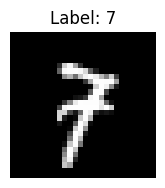

In [6]:
# Use the built-in next() function to get a batch of data
example_data, example_targets = next(examples)
print(example_data[0].shape)

plt.subplot(2, 3, 4)
plt.imshow(example_data[0][0], cmap='gray')  # Visualize the first channel (grayscale)
plt.title(f'Label: {example_targets[0]}')
plt.axis('off')
plt.show()




In [80]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Reduced to 16 filters
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Reduced to 32 filters
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [81]:
# Instantiate the model
model = CNN()


In [82]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [83]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [84]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.18729328927891786
Epoch 2/5, Loss: 0.051561486816454706
Epoch 3/5, Loss: 0.03589053886965154
Epoch 4/5, Loss: 0.02685702528568359
Epoch 5/5, Loss: 0.022429643981455357


In [85]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 98.82%


In [71]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn.pth')

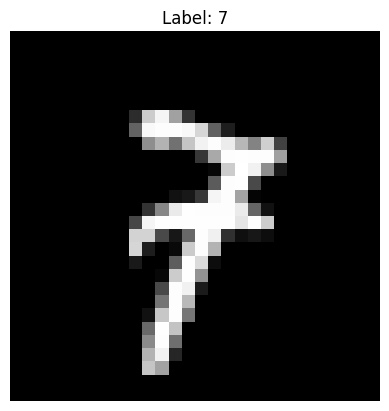

In [72]:
# Visualize feature maps
input_tensor = example_data[0].unsqueeze(0).to(device)  # Add batch dimension
input_tensor = input_tensor.unsqueeze(0)  # Add channel dimension (1, 1, 28, 28)

# Display the original image
plt.imshow(example_data[0][0], cmap='gray')  # Original 2D image
plt.title(f'Label: {example_targets[0]}')  # Use the corresponding label
plt.axis('off')  # Hide axes for better visualization
plt.show()

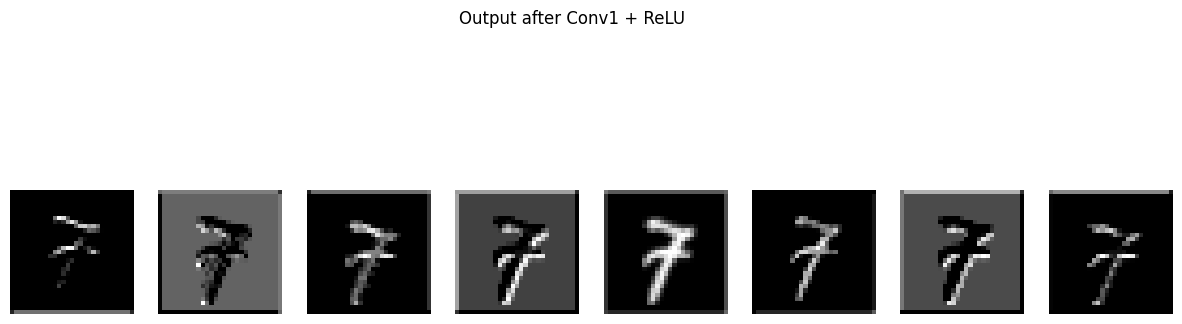

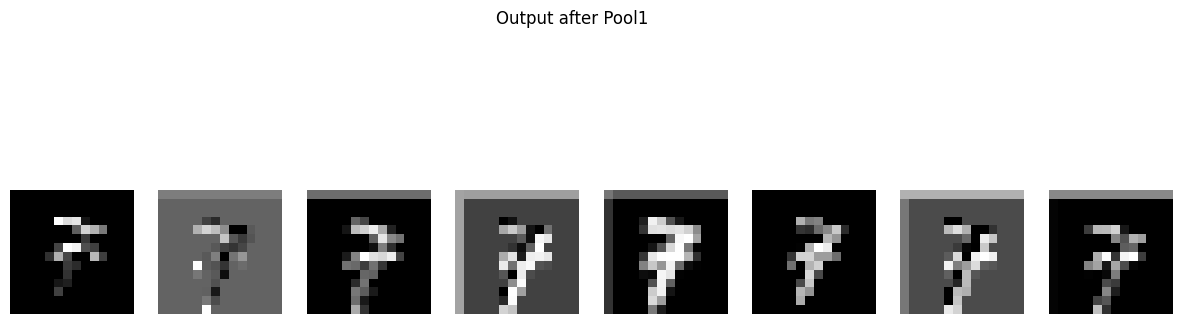

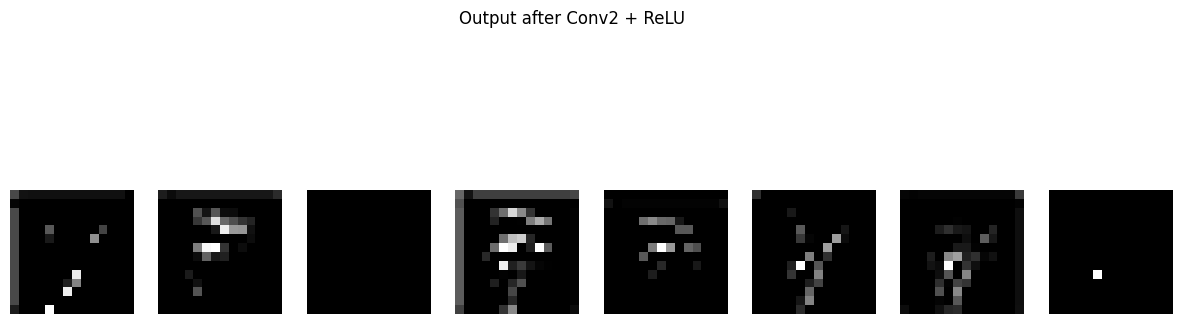

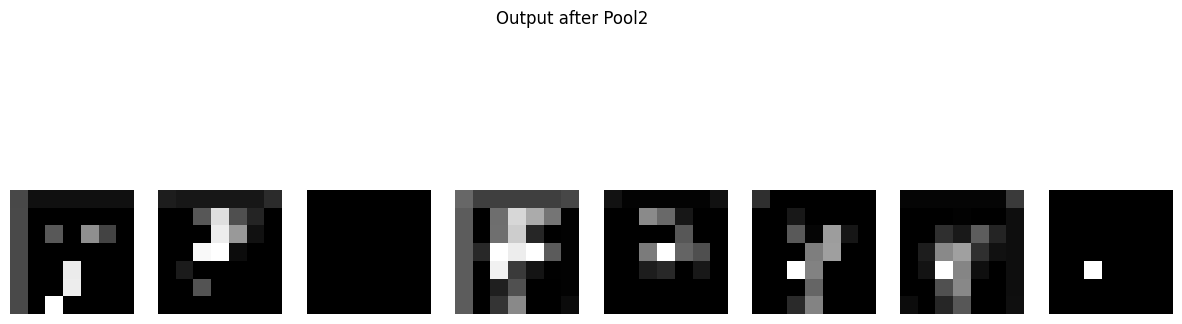

In [73]:
# Forward pass with visualization
with torch.no_grad():
    # Ensure input tensor has shape [batch_size, channels, height, width]
    input_tensor = example_data[0].unsqueeze(0)  # Add batch dimension, shape: [1, 1, 28, 28]

    # Step 1: First convolution + activation
    conv1_output = F.relu(model.conv1(input_tensor))
    plot_feature_maps(conv1_output, "Output after Conv1 + ReLU")

    # Step 2: First pooling
    pool1_output = model.pool(conv1_output)
    plot_feature_maps(pool1_output, "Output after Pool1")

    # Step 3: Second convolution + activation
    conv2_output = F.relu(model.conv2(pool1_output))
    plot_feature_maps(conv2_output, "Output after Conv2 + ReLU")

    # Step 4: Second pooling
    pool2_output = model.pool(conv2_output)
    plot_feature_maps(pool2_output, "Output after Pool2")
